## Установка библиотек

In [1]:
!pip install darts >> None

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from darts import TimeSeries
from darts.datasets import AirPassengersDataset
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Предобработка

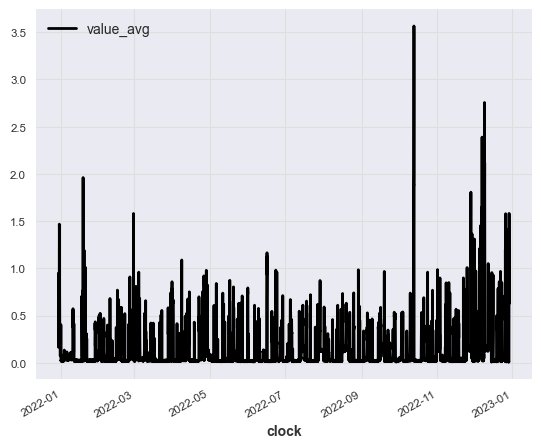

In [3]:
series = pd.read_csv('history_one_metric_cleared.csv')
series['clock'] = pd.to_datetime(series.clock)
series = series[['clock', 'value_avg']]
series.set_index('clock', inplace=True)

series = TimeSeries.from_dataframe(series)
series.plot()

## Визуализация

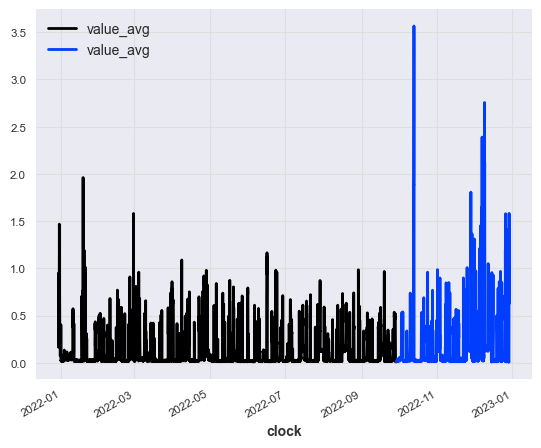

In [4]:
series1, series2 = series.split_before(0.75)
series1.plot()
series2.plot()


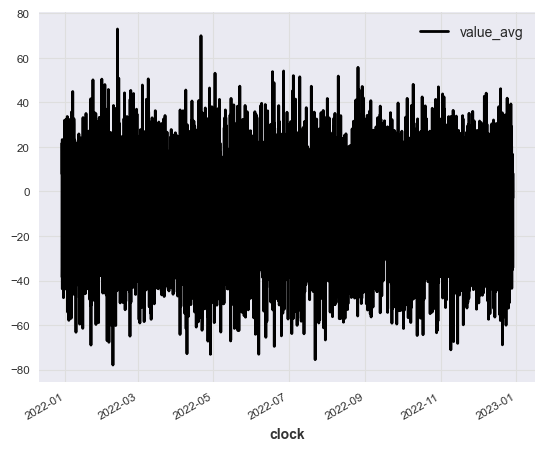

In [5]:
series_noise = TimeSeries.from_times_and_values(
    series.time_index, np.random.randn(len(series))
)
(series / 2 + 20 * series_noise - 10).plot()


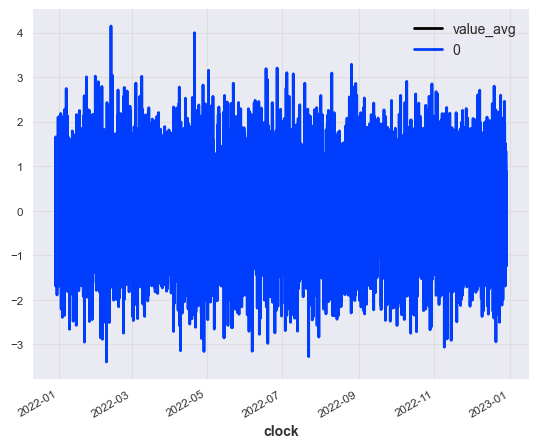

In [6]:
(series / 50).stack(series_noise).plot()

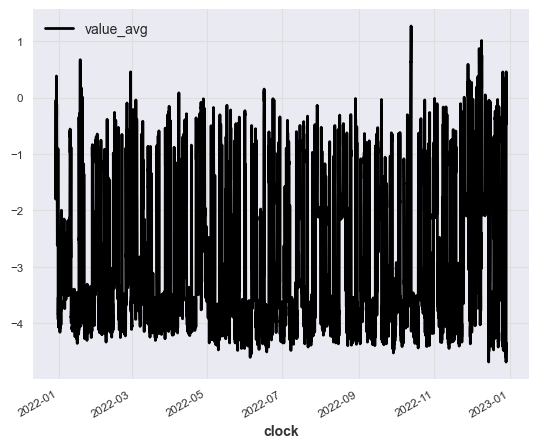

In [7]:
series.map(np.log).plot()


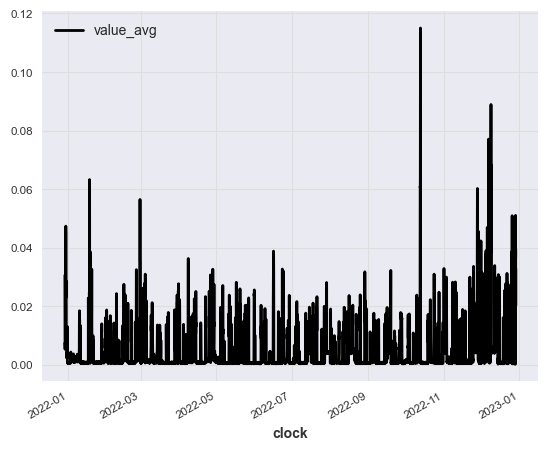

In [8]:
series.map(lambda ts, x: x / ts.days_in_month).plot()

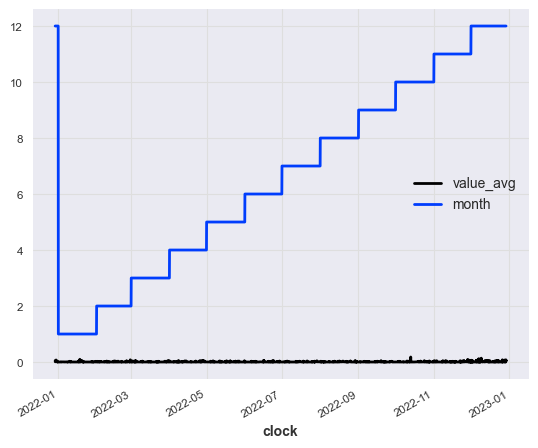

In [9]:
(series / 20).add_datetime_attribute("month").plot()


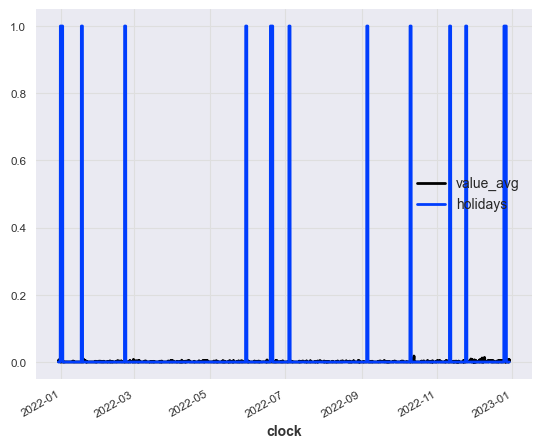

In [10]:
(series / 200).add_holidays("US").plot()

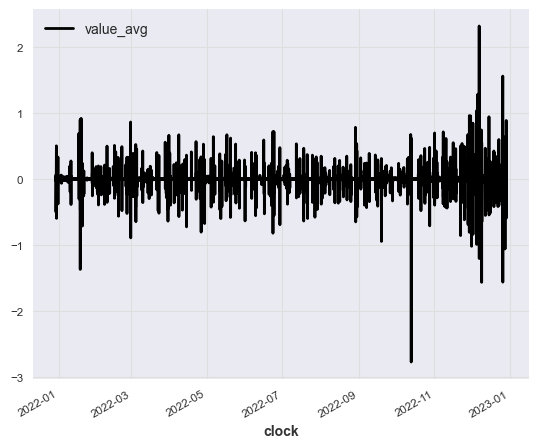

In [11]:
series.diff().plot()


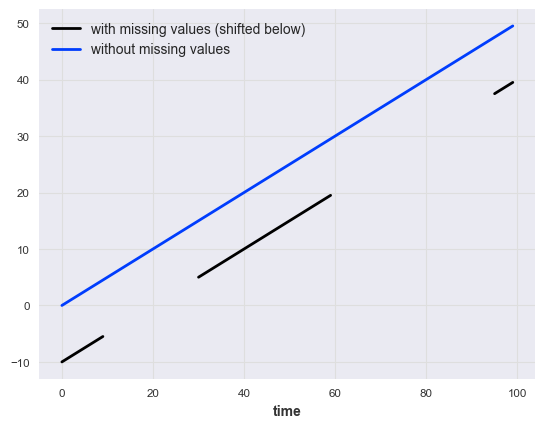

In [12]:
from darts.utils.missing_values import fill_missing_values

values = np.arange(50, step=0.5)
values[10:30] = np.nan
values[60:95] = np.nan
series_ = TimeSeries.from_values(values)

(series_ - 10).plot(label="with missing values (shifted below)")
fill_missing_values(series_).plot(label="without missing values")


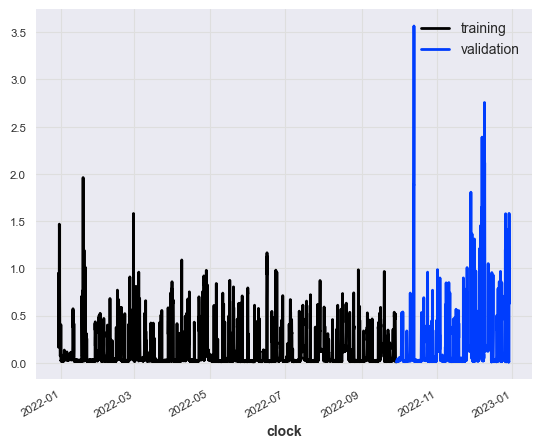

In [13]:
train, val = series.split_before(0.75)
train.plot(label="training")
val.plot(label="validation")


## Предсказание

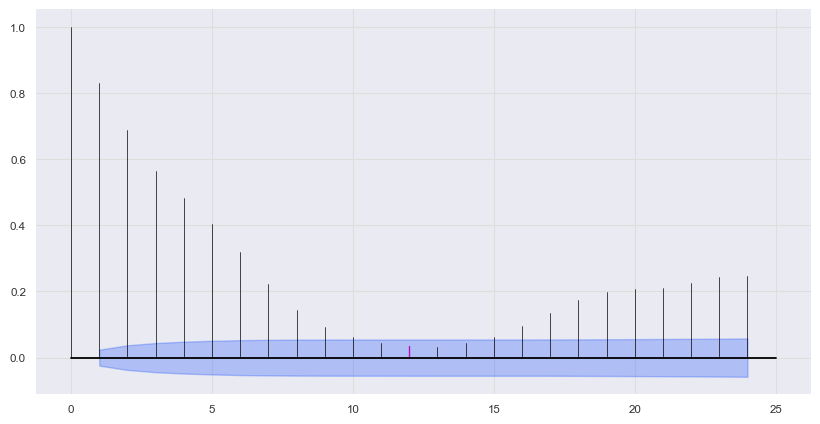

In [14]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train, m=12, alpha=0.05)


In [15]:
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

In [20]:
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta


def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print("model {} obtains MAPE: {:.2f}%".format(model, mape(val, forecast)))


eval_model(ExponentialSmoothing())
eval_model(TBATS())
eval_model(AutoARIMA())
eval_model(Theta())


model ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=24 obtains MAPE: 393.69%
model (T)BATS obtains MAPE: 95.42%
model Auto-ARIMA obtains MAPE: 207.35%
model Theta(2) obtains MAPE: 67.51%


In [21]:
from darts.metrics import mape
from darts.models import Theta
# Search for the best theta parameter, by trying 50 different values
thetas = 2 - np.linspace(-10, 10, 50)

best_mape = float("inf")
best_theta = 0

for theta in thetas:
    model = Theta(theta)
    model.fit(train)
    pred_theta = model.predict(len(val))
    res = mape(val, pred_theta)

    if res < best_mape:
        best_mape = res
        best_theta = theta

In [22]:
best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(len(val))

print(
    "The MAPE is: {:.2f}, with theta = {}.".format(
        mape(val, pred_best_theta), best_theta
    )
)

The MAPE is: 65.52, with theta = 0.16326530612244916.


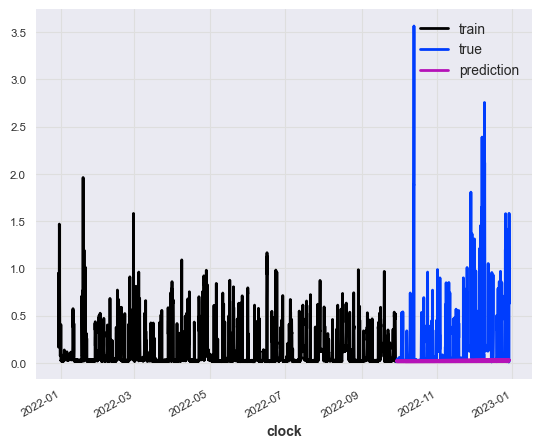

In [23]:
train.plot(label="train")
val.plot(label="true")
pred_best_theta.plot(label="prediction")


  0%|          | 0/3503 [00:00<?, ?it/s]

MAPE = 106.24%


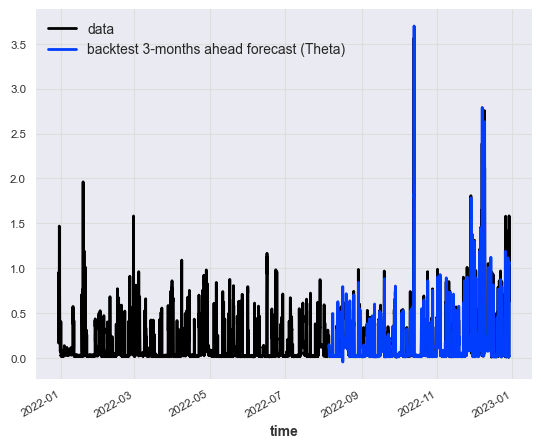

In [24]:
historical_fcast_theta = best_theta_model.historical_forecasts(
    series, start=0.6, forecast_horizon=3, verbose=True
)

series.plot(label="data")
historical_fcast_theta.plot(label="backtest 3-months ahead forecast (Theta)")
print("MAPE = {:.2f}%".format(mape(historical_fcast_theta, series)))


  0%|          | 0/3503 [00:00<?, ?it/s]

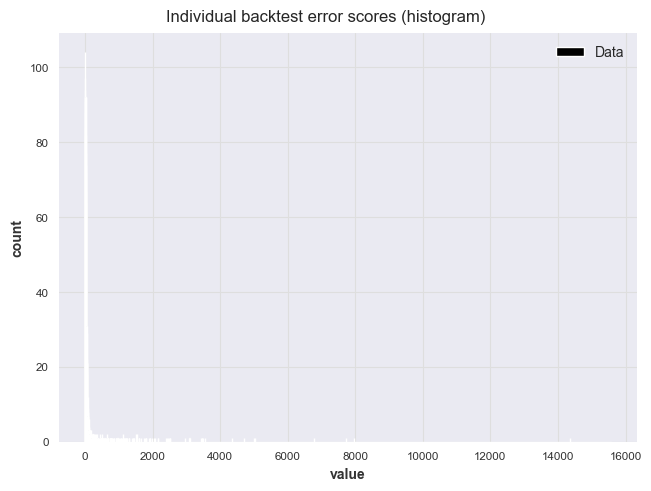

In [25]:
best_theta_model = Theta(best_theta)

raw_errors = best_theta_model.backtest(
    series, start=0.6, forecast_horizon=3, metric=mape, reduction=None, verbose=True
)

from darts.utils.statistics import plot_hist

plot_hist(
    raw_errors,
    bins=np.arange(0, max(raw_errors), 1),
    title="Individual backtest error scores (histogram)",
)


In [26]:
average_error = best_theta_model.backtest(
    series,
    start=0.6,
    forecast_horizon=3,
    metric=mape,
    reduction=np.mean,  # this is actually the default
    verbose=True,
)

print("Average error (MAPE) over all historical forecasts: %.2f" % average_error)


  0%|          | 0/3503 [00:00<?, ?it/s]

Average error (MAPE) over all historical forecasts: 100.48


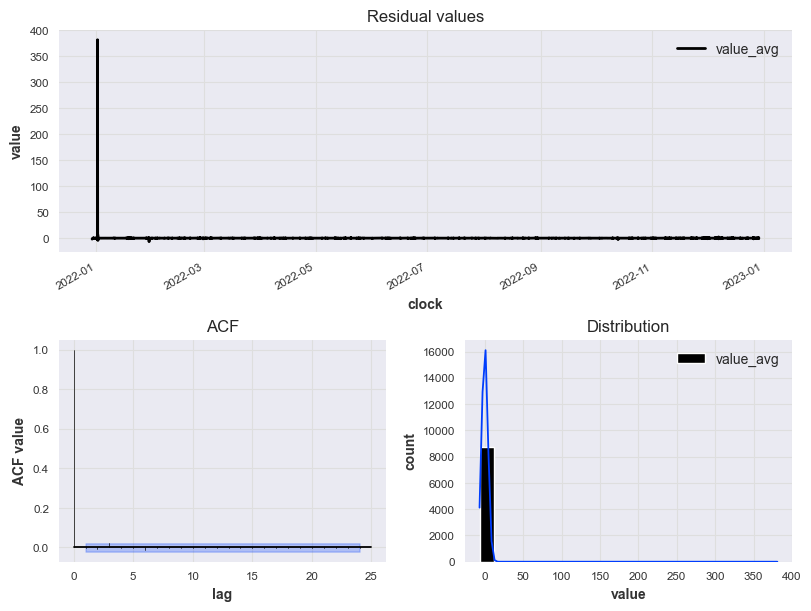

In [27]:
from darts.utils.statistics import plot_residuals_analysis

plot_residuals_analysis(best_theta_model.residuals(series))


  0%|          | 0/3503 [00:00<?, ?it/s]

MAPE = 408.93%


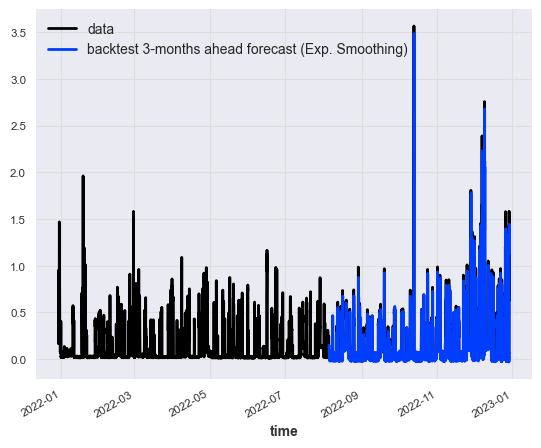

In [28]:
model_es = ExponentialSmoothing(seasonal_periods=12)
historical_fcast_es = model_es.historical_forecasts(
    series, start=0.6, forecast_horizon=3, verbose=True
)

series.plot(label="data")
historical_fcast_es.plot(label="backtest 3-months ahead forecast (Exp. Smoothing)")
print("MAPE = {:.2f}%".format(mape(historical_fcast_es, series)))


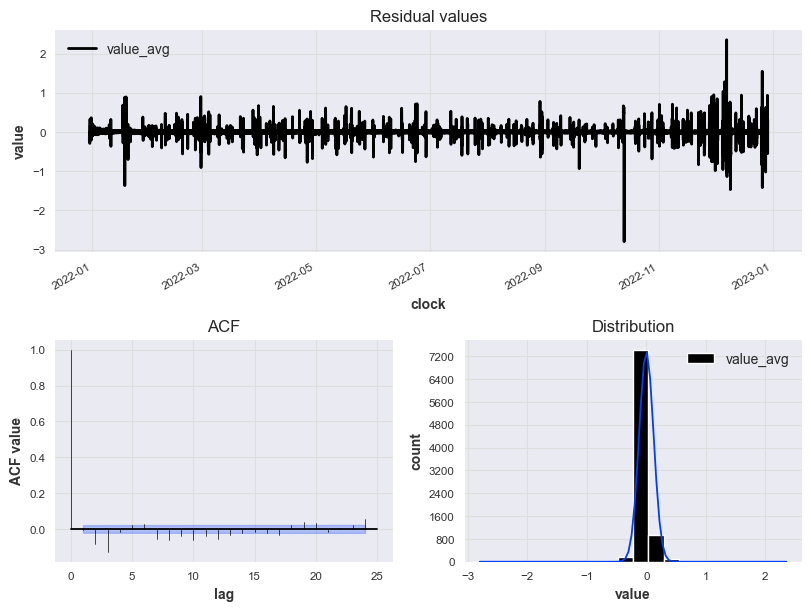

In [29]:
plot_residuals_analysis(model_es.residuals(series))

In [ ]:
from darts.models import TCNModel
from darts.utils.likelihood_models import LaplaceLikelihood
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

my_stopper = EarlyStopping(
    monitor="train_loss",
    patience=10,
    min_delta=0.1,
    mode='min',
)

model = TCNModel(
    input_chunk_length=24,
    output_chunk_length=12,
    random_state=42,
    likelihood=LaplaceLikelihood(),
    pl_trainer_kwargs={
        "accelerator": "gpu",
        "devices": [0],
        "callbacks": [my_stopper]
    },
)

model.fit(train, epochs=400, verbose=True);